##Week 4 Materail for ECEN 520L (Prof. Fatemeh Davoudi)

Decision trees are versatile machine learning algorithms that can perform both classification and regression tasks, and even multioutput tasks. They are powerful algorithms, capable of fitting complex datasets. <br>
Decision trees are also the fundamental components of random forests, which are among the most powerful machine learning algorithms available today.

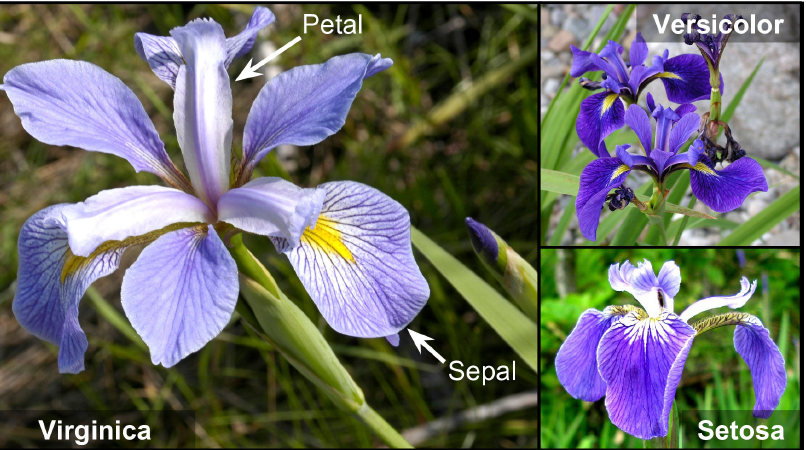

let's start by discussing how to train, visualize, and make predictions with decision trees. Then we will go through the CART training algorithm used by Scikit-Learn, and we will explore how to regularize trees and use them for regression tasks. Finally, we will discuss some of the limitations of decision trees.

**Training and Visualizing a Decision Tree**

To understand decision trees, let’s build one and take a look at how it makes predictions. The following code trains a DecisionTreeClassifier on the iris dataset.

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
tree_clf.fit(X_iris, y_iris)

DecisionTreeClassifier(max_depth=2, random_state=42)

You can visualize the trained decision tree by first using the export_graphviz() function to output a graph definition file called iris_tree.dot:

In [ ]:
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str("iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

Then you can use graphviz.Source.from_file() to load and display the file in a Colab notebook:

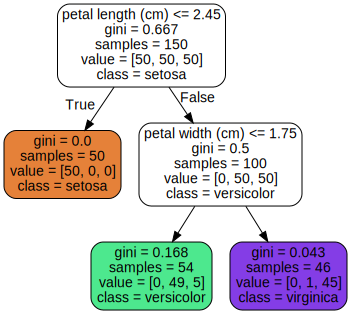

In [ ]:
from graphviz import Source

Source.from_file("iris_tree.dot")

Graphviz is an open source graph visualization software package. It also includes a dot command-line tool to convert .dot files to a variety of formats, such as PDF or PNG.

In [ ]:
# extra code
!dot -Tpng {"iris_tree.dot"} -o {"iris_tree.png"}

**Making Predictions**

Let’s see how the tree represented in following figure makes predictions. Suppose you find an iris flower and you want to classify it based on its petals. You start at the root node (depth 0, at the top): this node asks whether the flower’s petal length is smaller than 2.45 cm. If it is, then you move down to the root’s left child node (depth 1, left). In this case, it is a leaf node (i.e., it does not have any child nodes), so it does not ask any questions: simply look at the predicted class for that node, and the decision tree predicts that your flower is an Iris setosa (class=setosa). <br>
Now suppose you find another flower, and this time the petal length is greater than 2.45 cm. You again start at the root but now move down to its right child node (depth 1, right). This is not a leaf node, it’s a split node, so it asks another question: is the petal width smaller than 1.75 cm? If it is, then your flower is most likely an Iris versicolor (depth 2, left). If not, it is likely an Iris virginica (depth 2, right). It’s really that simple.<br>
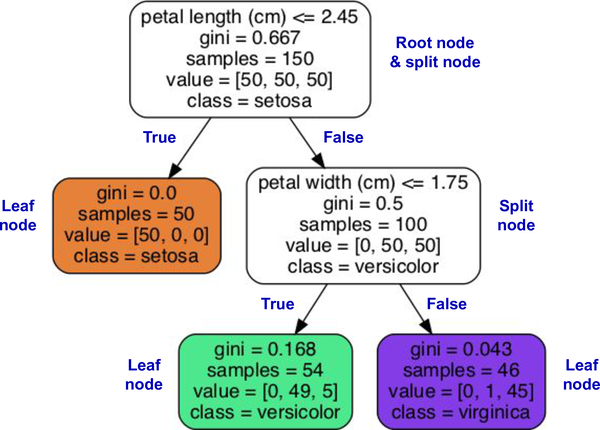

**NOTE** <br>
One of the many qualities of decision trees is that they require very little data preparation. In fact, they don’t require feature scaling or centering at all.

A node’s samples attribute counts how many training instances it applies to. For example, 100 training instances have a petal length greater than 2.45 cm (depth 1, right), and of those 100, 54 have a petal width smaller than 1.75 cm (depth 2, left). A node’s value attribute tells you how many training instances of each class this node applies to: for example, the bottom-right node applies to 0 Iris setosa, 1 Iris versicolor, and 45 Iris virginica. Finally, a node’s gini attribute measures its Gini impurity: a node is “pure” (gini=0) if all training instances it applies to belong to the same class. For example, since the depth-1 left node applies only to Iris setosa training instances, it is pure and its Gini impurity is 0. Following equation shows how the training algorithm computes the Gini impurity Gi of the $i^{th}$ node. The depth-2 left node has a Gini impurity equal to 1 – (0/54)2 – (49/54)2 – (5/54)2 ≈ 0.168. <br>

$G_i=1-\sum_{k=1}^{∞} p_{i,k}^2$ <br>
In this equation:


*   $G_i$ is the Gini impurity of the ith node.
*   $p_{i,k}$ is the ratio of class k instances among the training instances in the ith node.



**NOTE** <br>
Scikit-Learn uses the CART algorithm, which produces only binary trees, meaning trees where split nodes always have exactly two children (i.e., questions only have yes/no answers). However, other algorithms, such as ID3, can produce decision trees with nodes that have more than two children.

Following figure shows this decision tree’s decision boundaries. The thick vertical line represents the decision boundary of the root node (depth 0): petal length = 2.45 cm. Since the lefthand area is pure (only Iris setosa), it cannot be split any further. However, the righthand area is impure, so the depth-1 right node splits it at petal width = 1.75 cm (represented by the dashed line). Since max_depth was set to 2, the decision tree stops right there. If you set max_depth to 3, then the two depth-2 nodes would each add another decision boundary (represented by the two vertical dotted lines). <br>
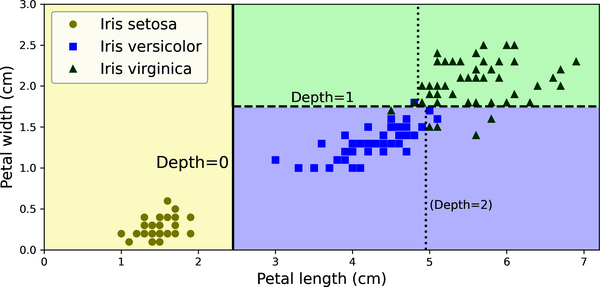

**Practice:** <br>
Train a decision tree model on Iris dataset (consider petal length and petal width as the inputs) with max_depth=3, and plot the tree with graphvis.

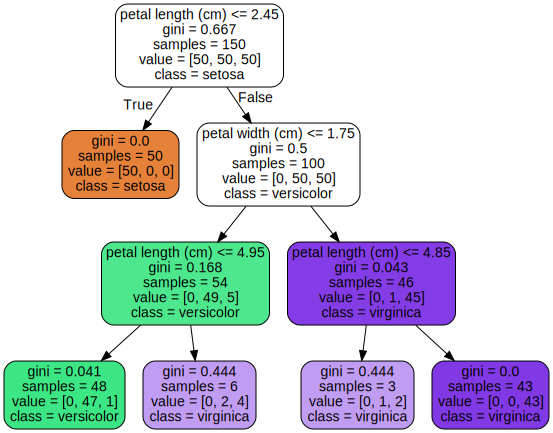

In [ ]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris(as_frame=True)
X_iris = iris.data[["petal length (cm)", "petal width (cm)"]].values
y_iris = iris.target

tree_clf = DecisionTreeClassifier(max_depth=3, random_state=42)
tree_clf.fit(X_iris, y_iris)


from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file=str("iris_tree.dot"),
        feature_names=["petal length (cm)", "petal width (cm)"],
        class_names=iris.target_names,
        rounded=True,
        filled=True
    )

from graphviz import Source

Source.from_file("iris_tree.dot")

**Estimating Class Probabilities**

A decision tree can also estimate the probability that an instance belongs to a particular class k. First it traverses the tree to find the leaf node for this instance, and then it returns the ratio of training instances of class k in this node. For example, suppose you have found a flower whose petals are 5 cm long and 1.5 cm wide. The corresponding leaf node is the depth-2 left node, so the decision tree outputs the following probabilities: 0% for Iris setosa (0/54), 90.7% for Iris versicolor (49/54), and 9.3% for Iris virginica (5/54). And if you ask it to predict the class, it outputs Iris versicolor (class 1) because it has the highest probability. Let’s check this:

In [ ]:
tree_clf.predict_proba([[5, 1.5]]).round(3)

array([[0.   , 0.907, 0.093]])

In [ ]:
tree_clf.predict([[5, 1.5]])

array([1])

Perfect! Notice that the estimated probabilities would be identical anywhere else in the bottom-right rectangle of following figure—for example, if the petals were 6 cm long and 1.5 cm wide (even though it seems obvious that it would most likely be an Iris virginica in this case). <br>
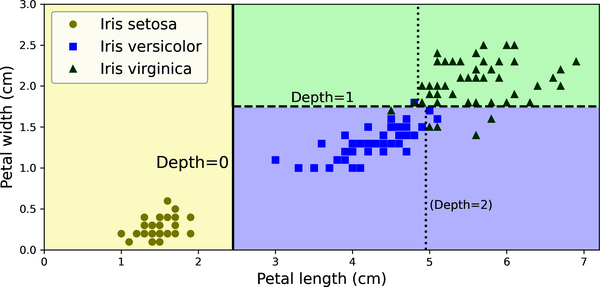

**The CART Training Algorithm**

Scikit-Learn uses the Classification and Regression Tree (CART) algorithm to train decision trees (also called “growing” trees). The algorithm works by first splitting the training set into two subsets using a single feature k and a threshold tk (e.g., “petal length ≤ 2.45 cm”). How does it choose k and tk? It searches for the pair (k, tk) that produces the purest subsets, weighted by their size. Following equation gives the cost function that the algorithm tries to minimize. <br>

$J(k, t_k)=\frac{m_{left}}{m}G_{left}+\frac{m_{right}}{m}G_{right}$ <br>

where:


*   $G_{left/right}$ measures the impurity of the left/right subset.
*   $m_{left/right}$ is the number of instances in the left/right subset.



Once the CART algorithm has successfully split the training set in two, it splits the subsets using the same logic, then the sub-subsets, and so on, recursively. It stops recursing once it reaches the maximum depth (defined by the max_depth hyperparameter), or if it cannot find a split that will reduce impurity. A few other hyperparameters (described in a moment) control additional stopping conditions: min_samples_split, min_samples_leaf, min_weight_fraction_leaf, and max_leaf_nodes.

**Regularization Hyperparameters**

Decision trees make very few assumptions about the training data (as opposed to linear models, which assume that the data is linear, for example). If left unconstrained, the tree structure will adapt itself to the training data, fitting it very closely—indeed, most likely overfitting it. Such a model is often called a nonparametric model, not because it does not have any parameters (it often has a lot) but because the number of parameters is not determined prior to training, so the model structure is free to stick closely to the data. In contrast, a parametric model, such as a linear model, has a predetermined number of parameters, so its degree of freedom is limited, reducing the risk of overfitting (but increasing the risk of underfitting)

To avoid overfitting the training data, you need to restrict the decision tree’s freedom during training. As you know by now, this is called regularization. The regularization hyperparameters depend on the algorithm used, but generally you can at least restrict the maximum depth of the decision tree. In Scikit-Learn, this is controlled by the max_depth hyperparameter. The default value is None, which means unlimited. Reducing max_depth will regularize the model and thus reduce the risk of overfitting.

The DecisionTreeClassifier class has a few other parameters that similarly restrict the shape of the decision tree:


*   **max_features:** Maximum number of features that are evaluated for splitting at each node

*   **max_leaf_nodes:** Maximum number of leaf nodes

*   **min_samples_split:** Minimum number of samples a node must have before it can be split
*   **min_samples_leaf:** Minimum number of samples a leaf node must have to be created


*   **min_weight_fraction_leaf:** Same as min_samples_leaf but expressed as a fraction of the total number of weighted instances


Increasing min_* hyperparameters or reducing max_* hyperparameters will regularize the model.





Let’s test regularization on the moons dataset. We’ll train one decision tree without regularization, and another with min_samples_leaf=5. Here’s the code.

In [ ]:
from sklearn.datasets import make_moons

X_moons, y_moons = make_moons(n_samples=150, noise=0.2, random_state=42)

tree_clf1 = DecisionTreeClassifier(random_state=42)
tree_clf2 = DecisionTreeClassifier(min_samples_leaf=5, random_state=42)
tree_clf1.fit(X_moons, y_moons)
tree_clf2.fit(X_moons, y_moons)

DecisionTreeClassifier(min_samples_leaf=5, random_state=42)

Following figure shows the decision boundaries of each tree: <br>
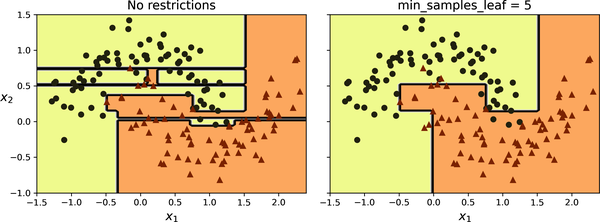

The unregularized model on the left is clearly overfitting, and the regularized model on the right will probably generalize better. We can verify this by evaluating both trees on a test set generated using a different random seed:

In [ ]:
X_moons_test, y_moons_test = make_moons(n_samples=1000, noise=0.2,
                                        random_state=43)
tree_clf1.score(X_moons_test, y_moons_test)

0.898

In [ ]:
tree_clf2.score(X_moons_test, y_moons_test)

0.92